In [140]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

In [141]:
"""Group 15 data science project
DATASET:
(https://www.kaggle.com/competitions/playground-series-s4e11/data)

PROCESS:
1. Load and clean the data
2. EDA - Exploring data
3. Data Pre-processing
4. Creating model
5. Cross-validated training
6. Evaluation of model
"""

'Group 15 data science project\nDATASET:\n(https://www.kaggle.com/competitions/playground-series-s4e11/data)\n\nPROCESS:\n1. Load and clean the data\n2. EDA - Exploring data\n3. Data Pre-processing\n4. Creating model\n5. Cross-validated training\n6. Evaluation of model\n'

In [142]:
"""
1. Loading and cleaning data

TODO:
We need a better way of handling NA values in certain columns - KNN encoding?
Run the DataAnalyser object before preprocessing (if verbose=True) such that it
can present information about the data before we start altering it
"""
cleaning_transformations = [
    {'drop': ['id', 'Name', 'City']},
    {'handle_na': []}
]

# Define Cleaner Class
class Cleaner(BaseEstimator, TransformerMixin):
    """
    This class will be used as part of the ML Pipeline for cleaning and handling data
    """
    def __init__(self, transformations):
        self.transformations = transformations
        self.data_analyser = DataAnalyser()

    def fit(self, x, y=None):
      # self.data_analyser.view_cleaning_analysis(x, y)
      return self

    def transform(self, x):
        x_temp = x.copy()

        for transformation in self.transformations:
            for transformation_type, column_names in transformation.items():
                if transformation_type == 'handle_na':
                    x_temp = self.deal_with_na_values(x_temp)
                elif transformation_type == 'drop':
                    x_temp = self.drop_unneeded_columns(x_temp, column_names)

        return x_temp

    @staticmethod
    def deal_with_na_values(data, verbose=False):

      mode_fill_columns = ['Financial Stress', 'Dietary Habits']
      zero_fill_column = ['CGPA', 'Degree', 'Profession', 'Academic Pressure',
                          'Study Satisfaction', 'Job Satisfaction',
                          'Work Pressure']

      for col in mode_fill_columns:
        data[col] = data[col].fillna(data[col].mode()[0])

      for col in zero_fill_column:
        data[col] = data[col].fillna(0)

      return data

    @staticmethod
    def drop_unneeded_columns(data, column_names):
        return data.drop(columns=column_names)

In [143]:
"""
2. EDA - This is the class that will allow us to display information about the data
         The idea is that this information that we can extract/plot will allow us to tweak out data-preprocessing pipeline
         to achieve better and more generalisable results

         TODO:
         Assess the overall distribution of 'Depressed' and 'not depressed' individuals in the dataset
         Confimatory factor analysis - or another method of figuring out how we can best assess each variables affect in building up
                                       a model which can generalise and help predict which variables affect the overall ability of the model
         look on kaggle for methods other users have used to
"""
class DataAnalyser:
  def __init__(self, dataframe=None, target=None):
    self.df = dataframe
    self.target = target

  def view_cleaning_analysis(self, dataframe=None, target=None):
    if dataframe is not None:
      self.df = dataframe
    if target is not None:
      self.target = target

    self.column_summary()
    # self.plot_columns()
    self.plot_column_distribution()
    self.plot_correlation_matrix()

  def view_pre_processing_analysis(self, dataframe=None):
    if dataframe is not None:
      self.df = dataframe
    self.perform_t_test()

  def plot_column_distribution(self):
    print('PLOTTING COLUMNS')
    # TODO: Verify we have each important column covered
    plots = {'pie_chart': ['Age'] ,
              'bar_graph': ['Have you ever had suicidal thoughts ?'],
              'box_plot': []}
    # plots = {'pie_chart': ['Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'] ,
    #           'bar_graph': ['Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'],
    #           'box_plot': ['Age']}

    for plot_type, columns in plots.items():
      if plot_type == 'pie_chart':
        self.plot_distribution_by_depression(columns)
      elif plot_type == 'bar_graph':
        self.plot_bar_graph(columns)
      elif plot_type == 'box_plot':
        self.plot_box_plot(columns)

  def plot_columns(self):
    print("*" * 50)
    print("PLOTTING EACH COLUMN")
    print("*" * 50)

    for col in self.df.columns:
      plt.figure(figsize=(8, 4))
      print(f"Plotting: {col}")

      if pd.api.types.is_numeric_dtype(self.df[col]):
        sns.boxplot(x=self.df[col])
        plt.title(f'Boxplot of {col}')
      else:
        sns.countplot(x=self.df[col], order=self.df[col].value_counts().index[:20])  # limit to top 20 if too many
        plt.title(f'Countplot of {col}')

      plt.tight_layout()
      plt.show()
      print("-" * 50)

  def column_summary(self):
    print("*" * 50)
    print("COLUMN SUMMARY")
    print("*" * 50)

    for col in self.df.columns:
      col_type = 'Numerical' if pd.api.types.is_numeric_dtype(self.df[col]) else 'Categorical'
      null_count = self.df[col].isnull().sum()
      null_percent = (null_count / len(self.df)) * 100

      print(f"Column: {col}")
      print(f"Type: {col_type}")
      print(f"Nulls: {null_count} ({null_percent:.2f}%)")
      print("-" * 50)

  def plot_correlation_matrix(self):
    print('*' * 50)
    print('* Correlation Matrices by Depression Status')
    print('*' * 50)

    # Select numerical and categorical columns
    numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = self.df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Separate datasets
    depressed_df = self.df[self.target == 1]
    non_depressed_df = self.df[self.target == 0]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    mask = np.triu(np.ones_like(depressed_df[numerical_cols].corr(), dtype=bool))
    cmap = sns.diverging_palette(230, 30, as_cmap=True)

    # Depressed correlation matrix (only numerical)
    sns.heatmap(
        depressed_df[numerical_cols].corr(),
        mask=mask,
        cmap=cmap,
        center=0,
        square=False,
        linewidths=0.5,
        cbar_kws={"shrink": 0.7},
        annot=True,
        fmt=".2f",
        annot_kws={"fontsize": 8},
        ax=axes[0]
    )
    axes[0].set_title("Correlation Matrix - Depressed", fontsize=13)

    # Non-depressed correlation matrix (only numerical)
    sns.heatmap(
        non_depressed_df[numerical_cols].corr(),
        mask=mask,
        cmap=cmap,
        center=0,
        square=False,
        linewidths=0.5,
        cbar_kws={"shrink": 0.7},
        annot=True,
        fmt=".2f",
        annot_kws={"fontsize": 8},
        ax=axes[1]
    )
    axes[1].set_title("Correlation Matrix - Not Depressed", fontsize=13)

    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', labelsize=8)

    plt.tight_layout()
    plt.show()

    # Optionally, display categorical data separately
    print("Categorical Columns in the Dataset:")
    print(categorical_cols)


  # def perform_t_test(self):
  #   # take the whole dataset, for each column in whole dataset, we are going split into
  #   #   depressed vs non-depressed - fnid t test - save value and column
  #   #   then sort column and show the columns with most breakdown
  #   print('*'*50)
  #   print('* Displaying T test per column')
  #   print('*'*50)
  def perform_t_test(self):
      print('*' * 50)
      print('* Displaying T-test per column')
      print('*' * 50)

      results = []

      # Separate the dataset
      depressed_df = self.df[self.target == 1]
      non_depressed_df = self.df[self.target == 0]

      for column in self.df.columns:
          # Only perform t-test on numeric columns (categorical would need chi-squared)
          if pd.api.types.is_numeric_dtype(self.df[column]):
              try:
                  stat, p_value = ttest_ind(depressed_df[column].dropna(), non_depressed_df[column].dropna(), equal_var=False)
                  results.append({
                      "Column": column,
                      "T-statistic": stat,
                      "P-value": p_value,
                      "Significant (< 0.05)": p_value < 0.05
                  })
              except Exception as e:
                  print(f"Could not perform t-test on column '{column}': {e}")

      # Convert results to DataFrame and sort by p-value
      results_df = pd.DataFrame(results).sort_values(by="P-value")

      print(results_df.to_string(index=False))


  def plot_distribution_by_depression(self, columns):
    for column in columns:
      # Copy and add "type" column to each group safely
      depressed_df = self.df[self.target == 1][[column]].copy()
      depressed_df["Depression Status"] = "Depressed"

      non_depressed_df = self.df[self.target == 0][[column]].copy()
      non_depressed_df["Depression Status"] = "Not Depressed"

      # Combine into one DataFrame
      combined_df = pd.concat([depressed_df, non_depressed_df])

      # Plot
      fig = px.histogram(
          data_frame=combined_df,
          x=column,
          color="Depression Status",
          color_discrete_sequence=['#E74C3C', '#2ECC71'],
          marginal="box",
          nbins=100,
          template="plotly_white"
      )

      fig.update_layout(title=f"Distribution of {column} by Depression Status", title_x=0.5)
      fig.show()

  def plot_bar_graph(self, columns):
    for column in columns:
      depressed_df = self.df[self.target == 1][[column]].copy()
      depressed_df["Depression Status"] = "Depressed"

      non_depressed_df = self.df[self.target == 0][[column]].copy()
      non_depressed_df["Depression Status"] = "Not Depressed"

      # Combine into one DataFrame
      combined_df = pd.concat([depressed_df, non_depressed_df])
      # code for plotting bar graph

      fig = px.histogram(
          data_frame=combined_df,
          x=column,
          color="Depression Status",
          barmode='group',
          histnorm='percent',
          color_discrete_sequence=['#E74C3C', '#2ECC71'],
          template="plotly_white"
      )

      fig.update_layout(
          title=f"{column} Distribution by Depression Status",
          title_x=0.5,
          xaxis_title=column,
          yaxis_title='Percentage',
          bargap=0.2
      )
      fig.show()



  def plot_box_plot(self, columns):
    for column in columns:
      depressed_df = self.df[self.target == 1][column]
      non_depressed_df = self.df[self.target == 0][column]
      # code for plotting box_plot

In [144]:
"""
3. Data Pre-Processing

COLUMNS -
id: Can be dropped
Name: Can be dropped
Gender: binary encoding
age: Normalised
city: Can be dropped
Working professional or Student: Binary encoding
Profession: Frequency-encoding
Academic Pressure: Normalised
Work Pressure: Normalised
CGPA: Normalised
Study Satisfaction: Normalised
Job Satisfaction: Normalised
Sleep Duration: mapped to values and normalised
Dietary Habits: mapped to values and normalised
Degree: Frequency encoding
Suicidal Thoughts: Binary Encoding
Work/Study Hours: Normalised
Financial stress: Normalised
Mental Illness: Binary Encoding
Depression: Target variable (no pre-processing needed)

TODO:

"""

# Basic preprocessing configuration
preprocessing_transformations = [
    {'binary_encode': ['Gender', 'Have you ever had suicidal thoughts ?',
                       'Family History of Mental Illness',
                       'Working Professional or Student']},
    {'map_sleep_column': ['Sleep Duration']},
    {'map_diet_column': ['Dietary Habits']},
    {'frequency_encode': ['Profession', 'Degree']},
    {'normalise': ['Financial Stress', 'Age', 'Academic Pressure', 'Work Pressure',
                   'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']}
]


class PreProcessor(BaseEstimator, TransformerMixin):
    """
    This class will handle the Pre-Processin of our data before passing to the Model

    """
    def __init__(self, transformations):
        self.transformations = transformations
        self.mappings = {
            'Gender': {'Male': 0, 'Female': 1},
            'Have you ever had suicidal thoughts ?': {'Yes': 0, 'No': 1},
            'Family History of Mental Illness': {'Yes': 0, 'No': 1},
            'Working Professional or Student': {'Working Professional': 0, 'Student': 1},
        }
        self.sleep_mapping = {
        "More than 8 hours":9,
        'Less than 5 hours':4,
        '5-6 hours':5.5,
        '7-8 hours':7.5,
        '1-2 hours':1.5,
        '6-8 hours':7,
        '4-6 hours':5,
        '6-7 hours':6.5,
        '10-11 hours':10.5,
        '8-9 hours':8.5,
        '9-11 hours':10,
        '2-3 hours':2.5,
        '3-4 hours':3.5,
        'Moderate':6,
        '4-5 hours':4.5,
        '9-6 hours':7.5,
        '1-3 hours':2,
        '1-6 hours':4,
        '8 hours':8,
        '10-6 hours':8,
        'Unhealthy':3,
        'Work_Study_Hours':6,
        '3-6 hours':4.5,
        '9-5':7,
        '9-5 hours':7,
        }
        self.diet_mapping ={
            'More Healty':0,
            'Healthy':1,
            'Less than Healthy':2,
            'Less Healthy':2,
            'Moderate':3,
            'Unhealthy':4,
            'No Healthy':4,
        }

    def fit(self, x, y=None):
      self.data_analyser = DataAnalyser(x, y)
      self.data_analyser.view_cleaning_analysis()
      return self

    def transform(self, x):
        x_temp = x.copy()

        for transformation in self.transformations:
            for transformation_name, column_names in transformation.items():
                if transformation_name == 'drop_columns':
                    x_temp = self.drop_columns(x_temp, column_names)
                elif transformation_name == 'binary_encode':
                    x_temp = self.encode_columns(x_temp, column_names, self.mappings)
                elif transformation_name == 'normalise':
                    x_temp = self.normalise_columns(x_temp, column_names)
                elif transformation_name == 'map_sleep_column':
                    x_temp = self.map_sleep_values(x_temp, column_names, self.sleep_mapping)
                elif transformation_name == 'frequency_encode':
                    x_temp = self.frequency_encode(x_temp, column_names)
                elif transformation_name == 'map_diet_column':
                    x_temp = self.map_dietary_value(x_temp, column_names, self.diet_mapping)

        # print('*'*50)
        # self.data_analyser.view_cleaning_analysis(x_temp)
        # print('*'*50)
        self.data_analyser.view_pre_processing_analysis(x_temp)

        return x_temp

    @staticmethod
    def drop_columns(data, column_names):
        data.drop(columns=column_names, inplace=True)
        return data

    @staticmethod
    def encode_columns(data, column_names, mappings):
        for column in column_names:
            if column in mappings:
                data[column] = data[column].map(mappings[column])
        return data

    @staticmethod
    def map_sleep_values(data, column_names, mapping):
        for column in column_names:
            data[column] = data[column].map(mapping)
            data[column] = data[column].fillna(data[column].mode()[0])
        return data

    @staticmethod
    def map_dietary_value(data, column_names, mapping):
        for column in column_names:
            data[column] = data[column].map(mapping)
            data[column] = data[column].fillna(data[column].mode()[0])
        return data


    @staticmethod
    def frequency_encode(data, column_names):
        for column in column_names:
            if column in data.columns:
                freq = data[column].value_counts() / len(data)
                data[column] = data[column].map(freq)
        return data

    @staticmethod
    def one_hot_encode(data, column_names):
        for column in column_names:
            if column in data.columns:
                one_hot = pd.get_dummies(data[column], prefix=column)
                data = pd.concat([data, one_hot], axis=1)
                data.drop(columns=[column], inplace=True)
        return data

    @staticmethod
    def normalise_columns(data, column_names):
        scaler = MinMaxScaler()  # Initialize MinMaxScaler
        for column in column_names:
            if column in data.columns:
                # Reshape for MinMaxScaler since it expects 2D input
                data[column] = scaler.fit_transform(data[[column]])
        return data

In [145]:
"""
4. Creating Model / Training / Evaluating

TODO:
save TP, TN, FP, FN values for each iteration, save all values and average them
"""

# Define model parameters
logistic_regression_params = {'max_iter': 1000, 'random_state': 42}
decision_tree_params = {'criterion': 'gini', 'max_depth': 3, 'random_state': 42}
random_forest_params = {'n_estimators': 100, 'max_depth': 5, 'random_state': 42}
svm_params = {'kernel': 'linear', 'C': 1.0}
knn_params = {'n_neighbors': 5}


# Define models
models = {'Logistic_regression': LogisticRegression(**logistic_regression_params),
          'decision_tree': DecisionTreeClassifier(**decision_tree_params),
          'random_forest': RandomForestClassifier(**random_forest_params)}
# models.append({'SVM': SVC(**svm_params)})
# models.append({'K-Nearest Neighbors': KNeighborsClassifier(**knn_params)})

class Trainer(BaseEstimator, TransformerMixin):

  def __init__(self, models, n_splits=5):
    self.models = models
    self.n_splits = n_splits
    self.results = {}
    self.results_analyser = ResultsAnalyser()

  def fit(self,x,y):
    skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)

    for model_name, model in self.models.items():
      accuracies = []
      tp_percentages, tn_percentages, fp_percentages, fn_percentages = [], [], [], []
      for train_idx, val_idx in skf.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        accuracy = accuracy_score(y_val, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        # Total samples in fold
        total = len(y_val)

        # Store percentages
        tp_percentages.append(tp / total)
        tn_percentages.append(tn / total)
        fp_percentages.append(fp / total)
        fn_percentages.append(fn / total)
        accuracies.append(accuracy)

      self.results[model_name] = {
        'accuracy': np.mean(accuracies),
        'tp%': np.mean(tp_percentages),
        'tn%': np.mean(tn_percentages),
        'fp%': np.mean(fp_percentages),
        'fn%': np.mean(fn_percentages)}
    return self

  def transform(self,x):
    return x

  def get_results(self):
    self.results_analyser.view_results(self.results)

In [146]:
'''
5. Analysing results
'''

class ResultsAnalyser:
    def __init__(self):
        pass

    def view_results(self, results, fp=None, fn=None, tp=None, tn=None):
        """
        General function that will display:
        1. Individual model results (accuracy, true positives, false positives, etc.)
        2. Confusion Matrix (if FP, FN, TP, TN are provided)
        3. Average F1 Score and Average Significance across all models

        Arguments:
        results : dict - Dictionary containing results from multiple models
        fp, fn, tp, tn : float - Confusion matrix values (optional)
        """

        # Display all the results for each model
        print('*' * 50)
        print('* Model Performance Results')
        print('*' * 50)
        for model_name, metrics in results.items():
            print(f"{model_name}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
            print("-" * 50)

        # Display confusion matrix (only if FP, FN, TP, TN are provided)
        if fp is not None and fn is not None and tp is not None and tn is not None:
            self.create_confusion_matrix(fp, fn, tp, tn)

        # Compute and display average F1 score and significance across all models
        self.compute_average_metrics(results)

    def create_confusion_matrix(self, fp, fn, tp, tn):
        """
        Create and display a confusion matrix.

        Arguments:
        fp : float - False Positive rate
        fn : float - False Negative rate
        tp : float - True Positive rate
        tn : float - True Negative rate

        Returns:
        None
        """
        # Compute confusion matrix values
        confusion_matrix = {
            "TP": tp,
            "TN": tn,
            "FP": fp,
            "FN": fn
        }

        print('*' * 50)
        print('* Confusion Matrix')
        print('*' * 50)
        print(f"True Positives (TP): {confusion_matrix['TP']}")
        print(f"True Negatives (TN): {confusion_matrix['TN']}")
        print(f"False Positives (FP): {confusion_matrix['FP']}")
        print(f"False Negatives (FN): {confusion_matrix['FN']}")
        print('*' * 50)

    def compute_average_metrics(self, results):
        """
        Compute the average of metrics such as F1 score and significance
        from a results dictionary.

        Arguments:
        results : dict - dictionary of model results with performance metrics

        Returns:
        avg_f1_score : float - Average F1 score of all models
        avg_significance : float - Average significance based on p-value
        """
        f1_scores = []
        significance_values = []

        # Loop through all the models in the results
        for model_name, metrics in results.items():
            accuracy = metrics.get('accuracy')
            tp_percentage = metrics.get('tp%')
            tn_percentage = metrics.get('tn%')
            fp_percentage = metrics.get('fp%')
            fn_percentage = metrics.get('fn%')

            # Compute F1 score (simplified formula for demonstration)
            f1 = 2 * (tp_percentage * tn_percentage) / (tp_percentage + tn_percentage)
            f1_scores.append(f1)

            # Significance (using p-value for now, assuming p-value < 0.05 is significant)
            p_value = metrics.get('p-value', 0.05)  # Default value for p-value if missing
            significance = p_value < 0.05
            significance_values.append(int(significance))

        # Calculate average F1 score and significance
        avg_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0
        avg_significance = sum(significance_values) / len(significance_values) if significance_values else 0

        print('*' * 50)
        print('* Average Metrics')
        print('*' * 50)
        print(f"Average F1 Score: {avg_f1_score:.2f}")
        print(f"Average Significance: {avg_significance:.2f} (where 1 = significant, 0 = not significant)")
        print('*' * 50)

        return avg_f1_score, avg_significance



**************************************************
COLUMN SUMMARY
**************************************************
Column: Gender
Type: Categorical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Age
Type: Numerical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Working Professional or Student
Type: Categorical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Profession
Type: Categorical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Academic Pressure
Type: Numerical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Work Pressure
Type: Numerical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: CGPA
Type: Numerical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Study Satisfaction
Type: Numerical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Job Satisfaction
Type: 

**************************************************
* Correlation Matrices by Depression Status
**************************************************


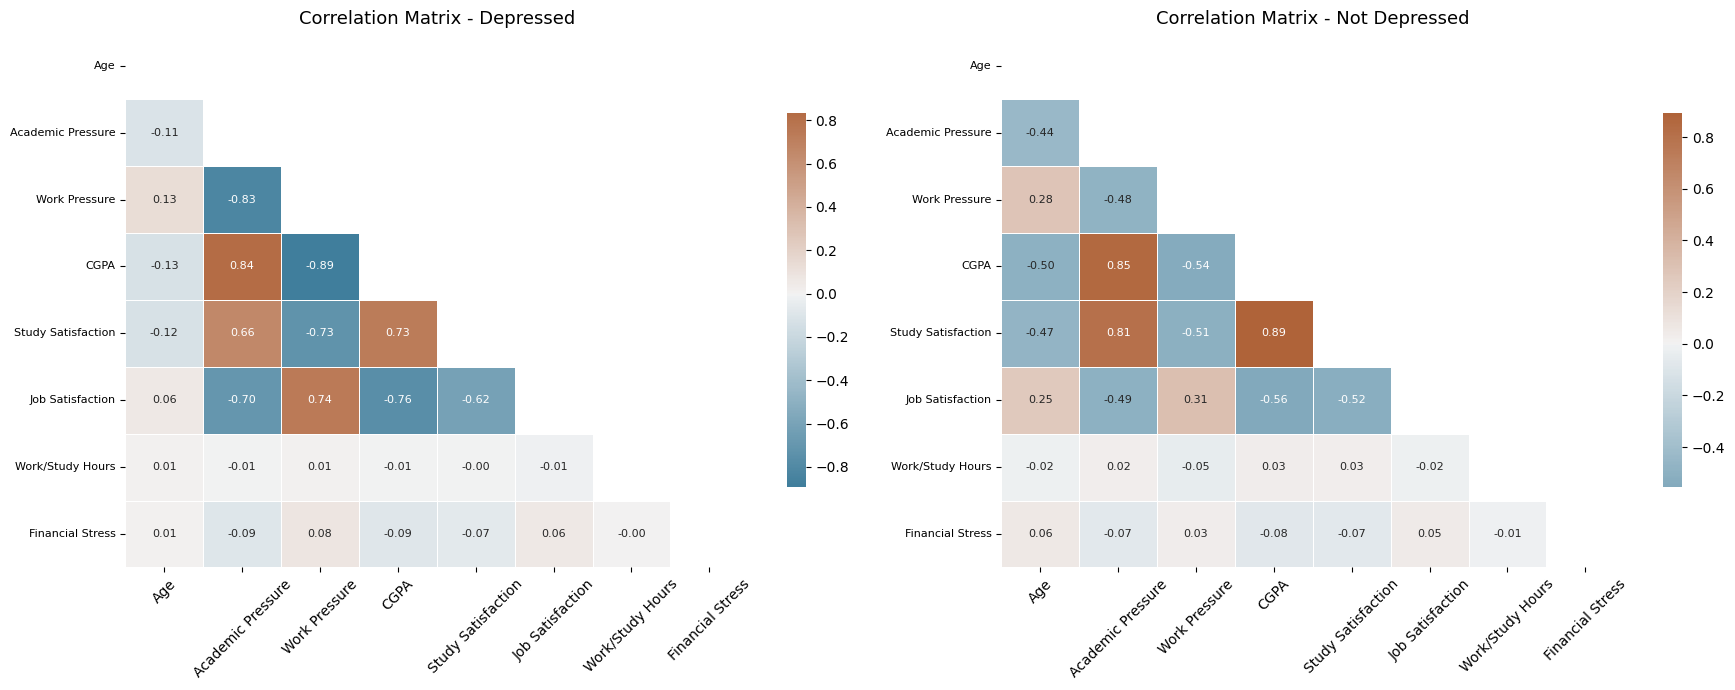

Categorical Columns in the Dataset:
['Gender', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
**************************************************
* Displaying T-test per column
**************************************************
                               Column  T-statistic       P-value  Significant (< 0.05)
                                  Age  -350.659244  0.000000e+00                  True
      Working Professional or Student   171.944851  0.000000e+00                  True
                           Profession   192.712988  0.000000e+00                  True
                    Academic Pressure   165.718192  0.000000e+00                  True
                                 CGPA   164.760308  0.000000e+00                  True
                        Work Pressure   -85.162218  0.000000e+00                  True
                   Study Satisfaction  

In [147]:
# Load the data
dataset = pd.read_csv('train.csv')

# Removing target Column
target = dataset.pop('Depression')

pipeline = Pipeline([
    ('cleaning', Cleaner(cleaning_transformations)),
    ('preprocessor', PreProcessor(preprocessing_transformations)),
    ('training', Trainer(models))
])

pipeline.fit(dataset, target)

model_results = pipeline.named_steps['training'].get_results()